In [1]:
import mxnet as mx
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Building a Variational Autoencoder in MXNet

#### Xiaoyu Lu,  July 5th, 2017

This tutorial guides you through the process of building a variational encoder in MXNet. In this notebook we'll focus on an example using the MNIST handwritten digit recognition dataset. Refer to [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114/) for more details on the model description.



## Prerequisites

To complete this tutorial, we need following python packages:

- numpy, matplotlib 

## 1. Loading the Data

We first load the MNIST dataset, which contains 60000 training and 10000 test examples. The following code imports required modules and loads the data. These images are stored in a 4-D matrix with shape (`batch_size, num_channels, width, height`). For the MNIST dataset, there is only one color channel, and both width and height are 28, so we reshape each image as a 28x28 array. See below for a visualization:


In [7]:
mnist = mx.test_utils.get_mnist()
image = np.reshape(mnist['train_data'],(60000,28*28))
label = image
image_test = np.reshape(mnist['test_data'],(10000,28*28))
label_test = image_test
[N,features] = np.shape(image)          #number of examples and features

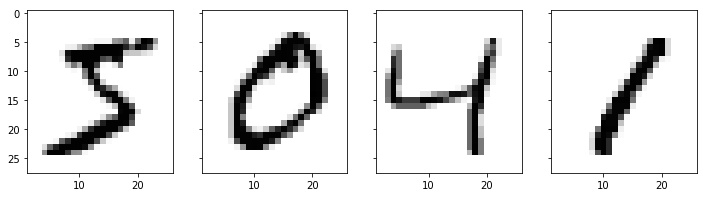

In [3]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,  sharex='col', sharey='row',figsize=(12,3))
ax1.imshow(np.reshape(image[0,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax2.imshow(np.reshape(image[1,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax3.imshow(np.reshape(image[2,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax4.imshow(np.reshape(image[3,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
plt.show()

We can optionally save the parameters in the directory variable 'model_prefix'. We first create data iterators for MXNet, with each batch of data containing 100 images.

In [4]:
model_prefix = None

batch_size = 100
nd_iter = mx.io.NDArrayIter(data={'data':image},label={'loss_label':label},
                            batch_size = batch_size)
nd_iter_test = mx.io.NDArrayIter(data={'data':image_test},label={'loss_label':label_test},
                            batch_size = batch_size)

## 2.  Building the Network Architecture

### 2.1 Gaussian MLP as encoder
Next we constuct the neural network, as in the [paper](https://arxiv.org/abs/1312.6114/), we use *Multilayer Perceptron (MLP)* for both the encoder and decoder. For encoder, a Gaussian MLP is used as follows:

\begin{align}
\log q_{\phi}(z|x) &= \log \mathcal{N}(z:\mu,\sigma^2I) \\
\textit{ where } \mu &= W_2h+b_2, \log \sigma^2 = W_3h+b_3\\
h &= \tanh(W_1x+b_1)
\end{align}

where $\{W_1,W_2,W_3,b_1,b_2,b_3\}$ are the weights and biases of the MLP.
Note below that `encoder_mu`(`mu`) and `encoder_logvar`(`logvar`) are symbols. So, we can use `get_internals()` to get the values of them, after which we can sample the latent variable $z$.





In [5]:
## define data and loss labels as symbols 
data = mx.sym.var('data')
loss_label = mx.sym.var('loss_label')

## define fully connected and activation layers for the encoder, where we used tanh activation function.
encoder_h  = mx.sym.FullyConnected(data=data, name="encoder_h",num_hidden=400)
act_h = mx.sym.Activation(data=encoder_h, act_type="tanh",name="activation_h")

## define mu and log variance which are the fully connected layers of the previous activation layer
mu  = mx.sym.FullyConnected(data=act_h, name="mu",num_hidden = 5)
logvar  = mx.sym.FullyConnected(data=act_h, name="logvar",num_hidden = 5)

## sample the latent variables z according to Normal(mu,var)
z = mu + np.multiply(mx.symbol.exp(0.5 * logvar), 
                     mx.symbol.random_normal(loc=0, scale=1, shape=np.shape(logvar.get_internals()["logvar_output"])))

### 2.2 Bernoulli MLP as decoder

In this case let $p_\theta(x|z)$ be a multivariate Bernoulli whose probabilities are computed from $z$ with a feed forward neural network with a single hidden layer:

\begin{align}
\log p(x|z) &= \sum_{i=1}^D x_i\log y_i + (1-x_i)\log (1-y_i) \\
\textit{ where }  y &= f_\sigma(W_5\tanh (W_4z+b_4)+b_5)
\end{align}

where $f_\sigma(\dot)$ is the elementwise sigmoid activation function, $\{W_4,W_5,b_4,b_5\}$ are the weights and biases of the decoder MLP. A Bernouilli likelihood is suitable for this type of data but you can easily extend it to other likelihood types by parsing into the argument `likelihood` in the `VAE` class, see section 4 for details.

In [6]:
# define fully connected and tanh activation layers for the decoder
decoder_z = mx.sym.FullyConnected(data=z, name="decoder_z",num_hidden=400)
act_z = mx.sym.Activation(data=decoder_z, act_type="tanh",name="activation_z")

# define the output layer with sigmoid activation function, where the dimension is equal to the input dimension
decoder_x = mx.sym.FullyConnected(data=act_z, name="decoder_x",num_hidden=features)
y = mx.sym.Activation(data=decoder_x, act_type="sigmoid",name='activation_x')

### 2.3 Joint Loss Function for the Encoder and the Decoder

The variational lower bound also called evidence lower bound (ELBO) can be estimated as:

\begin{align}
\mathcal{L}(\theta,\phi;x_{(i)}) \approx \frac{1}{2}\left(1+\log ((\sigma_j^{(i)})^2)-(\mu_j^{(i)})^2-(\sigma_j^{(i)})^2\right) + \log p_\theta(x^{(i)}|z^{(i)})
\end{align}

where the first term is the KL divergence of the approximate posterior from the prior, and the second term is an expected negative reconstruction error. We would like to maximize this lower bound, so we can define the loss to be $-\mathcal{L}$(minus ELBO) for MXNet to minimize.

In [7]:
# define the objective loss function that needs to be minimized
KL = 0.5*mx.symbol.sum(1+logvar-pow( mu,2)-mx.symbol.exp(logvar),axis=1)
loss = -mx.symbol.sum(mx.symbol.broadcast_mul(loss_label,mx.symbol.log(y)) 
                      + mx.symbol.broadcast_mul(1-loss_label,mx.symbol.log(1-y)),axis=1)-KL
output = mx.symbol.MakeLoss(sum(loss),name='loss')

## 3. Training the model

Now, we can define the model and train it. First we will initilize the weights and the biases to be Gaussian(0,0.01), and then use stochastic gradient descent for optimization. To warm start the training, one may also initilize with pre-trainined parameters `arg_params` using `init=mx.initializer.Load(arg_params)`. 

To save intermediate results, we can optionally use `epoch_end_callback = mx.callback.do_checkpoint(model_prefix, 1)` which saves the parameters to the path given by model_prefix, and with period every $1$ epoch. To assess the performance, we output $-\mathcal{L}$(minus ELBO) after each epoch, with the command `eval_metric = 'Loss'` which is defined above. We will also plot the training loss for mini batches by accessing the log and saving it to a list, and then parsing it to the argument `batch_end_callback`.

In [8]:
# set up the log
nd_iter.reset()
logging.getLogger().setLevel(logging.DEBUG)  

# define function to trave back training loss
def log_to_list(period, lst):
    def _callback(param):
        """The checkpoint function."""
        if param.nbatch % period == 0:
            name, value = param.eval_metric.get()
            lst.append(value)
    return _callback

# define the model
model = mx.mod.Module(
    symbol = output ,
    data_names=['data'],
    label_names = ['loss_label'])

In [9]:
# training the model, save training loss as a list.
training_loss=list()

# initilize the parameters for training using Normal.
init = mx.init.Normal(0.01)
model.fit(nd_iter,  # train data
          initializer=init,
          # if eval_data is supplied, test loss will also be reported
          # eval_data = nd_iter_test,
          optimizer='sgd',  # use SGD to train
          optimizer_params={'learning_rate':1e-3,'wd':1e-2},  
          # save parameters for each epoch if model_prefix is supplied
          epoch_end_callback = None if model_prefix==None else mx.callback.do_checkpoint(model_prefix, 1),
          batch_end_callback = log_to_list(N/batch_size,training_loss), 
          num_epoch=100,
          eval_metric = 'Loss')

INFO:root:Epoch[0] Train-loss=375.023381
INFO:root:Epoch[0] Time cost=6.127
INFO:root:Epoch[1] Train-loss=212.780315
INFO:root:Epoch[1] Time cost=6.409
INFO:root:Epoch[2] Train-loss=208.209400
INFO:root:Epoch[2] Time cost=6.619
INFO:root:Epoch[3] Train-loss=206.146854
INFO:root:Epoch[3] Time cost=6.648
INFO:root:Epoch[4] Train-loss=204.530598
INFO:root:Epoch[4] Time cost=7.000
INFO:root:Epoch[5] Train-loss=202.799992
INFO:root:Epoch[5] Time cost=6.778
INFO:root:Epoch[6] Train-loss=200.333474
INFO:root:Epoch[6] Time cost=7.187
INFO:root:Epoch[7] Train-loss=197.506393
INFO:root:Epoch[7] Time cost=6.712
INFO:root:Epoch[8] Train-loss=195.969775
INFO:root:Epoch[8] Time cost=6.896
INFO:root:Epoch[9] Train-loss=195.418288
INFO:root:Epoch[9] Time cost=6.887
INFO:root:Epoch[10] Train-loss=194.739763
INFO:root:Epoch[10] Time cost=6.745
INFO:root:Epoch[11] Train-loss=194.380536
INFO:root:Epoch[11] Time cost=6.706
INFO:root:Epoch[12] Train-loss=193.955462
INFO:root:Epoch[12] Time cost=6.592
INFO:r

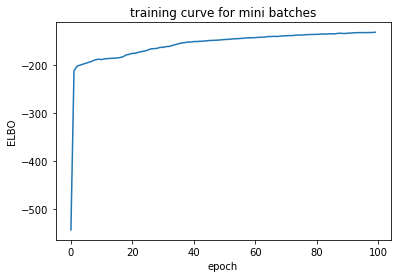

In [23]:
ELBO = [-training_loss[i] for i in range(len(training_loss))]
plt.plot(ELBO)
plt.ylabel('ELBO');plt.xlabel('epoch');plt.title("training curve for mini batches")
plt.show()

As expected, the ELBO is monotonically increasing over epoch, and we reproduced the results given in the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114/). Now we can extract/load the parameters and then feed the network forward to calculate $y$ which is the reconstructed image, and we can also calculate the ELBO for the test set. 

In [80]:
arg_params = model.get_params()[0]

# if saved the parameters, can load them using `load_checkpoint` method at e.g. 100th epoch
# sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 100)
# assert sym.tojson() == output.tojson()

e = y.bind(mx.cpu(), {'data': nd_iter_test.data[0][1],
                     'encoder_h_weight': arg_params['encoder_h_weight'],
                     'encoder_h_bias': arg_params['encoder_h_bias'],
                     'mu_weight': arg_params['mu_weight'],
                     'mu_bias': arg_params['mu_bias'],
                     'logvar_weight':arg_params['logvar_weight'],
                     'logvar_bias':arg_params['logvar_bias'],
                     'decoder_z_weight':arg_params['decoder_z_weight'],
                     'decoder_z_bias':arg_params['decoder_z_bias'],
                     'decoder_x_weight':arg_params['decoder_x_weight'],
                     'decoder_x_bias':arg_params['decoder_x_bias'],                
                     'loss_label':label})

x_fit = e.forward()
x_construction = x_fit[0].asnumpy()

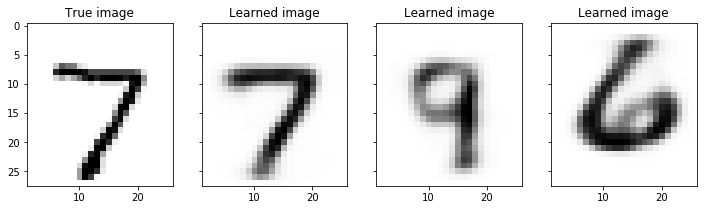

In [78]:
# learning images on the test set
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4,  sharex='col', sharey='row',figsize=(12,3))
ax1.imshow(np.reshape(image_test[0,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax1.set_title('True image')
ax2.imshow(np.reshape(x_construction[0,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax2.set_title('Learned image')
ax3.imshow(np.reshape(x_construction[999,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax3.set_title('Learned image')
ax4.imshow(np.reshape(x_construction[9999,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax4.set_title('Learned image')
plt.show()

In [37]:
# calculate the ELBO which is minus the loss for test set
metric = mx.metric.Loss()
model.score(nd_iter_test, metric)

[('loss', 139.73684648437501)]

## 4. All together: MXNet-based class VAE

In [2]:
from VAE import VAE

One can directly call the class `VAE` to do the training:

```VAE(n_latent=5,num_hidden_ecoder=400,num_hidden_decoder=400,x_train=None,x_valid=None,
batch_size=100,learning_rate=0.001,weight_decay=0.01,num_epoch=100,optimizer='sgd',model_prefix=None,
initializer = mx.init.Normal(0.01),likelihood=Bernoulli)```

The outputs are the learned model and training loss.

In [8]:
# can initilize weights and biases with the learned parameters as follows: 
# init = mx.initializer.Load(params)

# call the VAE, output model contains the learned model and training loss
out = VAE(n_latent=2, x_train=image, x_valid=None, num_epoch=200) 

INFO:root:Epoch[0] Train-loss=377.146422
INFO:root:Epoch[0] Time cost=5.989
INFO:root:Epoch[1] Train-loss=211.998043
INFO:root:Epoch[1] Time cost=6.303
INFO:root:Epoch[2] Train-loss=207.103096
INFO:root:Epoch[2] Time cost=7.368
INFO:root:Epoch[3] Train-loss=204.958183
INFO:root:Epoch[3] Time cost=7.530
INFO:root:Epoch[4] Train-loss=203.342700
INFO:root:Epoch[4] Time cost=8.887
INFO:root:Epoch[5] Train-loss=201.649251
INFO:root:Epoch[5] Time cost=9.147
INFO:root:Epoch[6] Train-loss=199.782661
INFO:root:Epoch[6] Time cost=8.924
INFO:root:Epoch[7] Train-loss=198.044015
INFO:root:Epoch[7] Time cost=8.920
INFO:root:Epoch[8] Train-loss=195.732077
INFO:root:Epoch[8] Time cost=8.857
INFO:root:Epoch[9] Train-loss=194.070547
INFO:root:Epoch[9] Time cost=9.216
INFO:root:Epoch[10] Train-loss=193.186871
INFO:root:Epoch[10] Time cost=8.966
INFO:root:Epoch[11] Train-loss=192.700208
INFO:root:Epoch[11] Time cost=8.843
INFO:root:Epoch[12] Train-loss=192.191504
INFO:root:Epoch[12] Time cost=8.152
INFO:r

In [12]:
# encode test images to obtain mu and logvar which are used for sampling
[mu,logvar] = VAE.encoder(out,image_test)
# sample in the latent space
z = VAE.sampler(mu,logvar)
# decode from the latent space to obtain reconstructed images
x_construction = VAE.decoder(out,z)


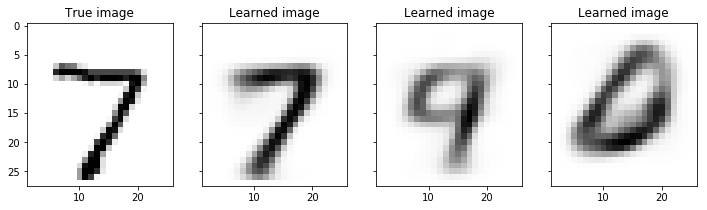

In [13]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4,  sharex='col', sharey='row',figsize=(12,3))
ax1.imshow(np.reshape(image_test[0,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax1.set_title('True image')
ax2.imshow(np.reshape(x_construction[0,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax2.set_title('Learned image')
ax3.imshow(np.reshape(x_construction[999,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax3.set_title('Learned image')
ax4.imshow(np.reshape(x_construction[9999,:],(28,28)), interpolation='nearest', cmap=cm.Greys)
ax4.set_title('Learned image')
plt.show()

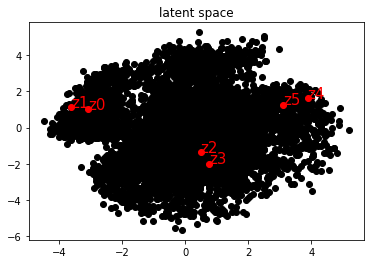

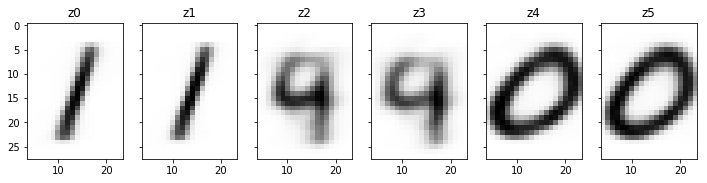

In [78]:
z1 = z[:,0]
z2 = z[:,1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z1,z2,'ko')
plt.title("latent space")

#np.where((z1>3) & (z2<2) & (z2>0))
#select the points from the latent space
a_vec = [2,5,7,789,25,9993]
for i in range(len(a_vec)):
    ax.plot(z1[a_vec[i]],z2[a_vec[i]],'ro')  
    ax.annotate('z%d' %i, xy=(z1[a_vec[i]],z2[a_vec[i]]), 
                xytext=(z1[a_vec[i]],z2[a_vec[i]]),color = 'r',fontsize=15)


f, ((ax0, ax1, ax2, ax3, ax4,ax5)) = plt.subplots(1,6,  sharex='col', sharey='row',figsize=(12,2.5))
for i in range(len(a_vec)):
    eval('ax%d' %(i)).imshow(np.reshape(x_construction[a_vec[i],:],(28,28)), interpolation='nearest', cmap=cm.Greys)
    eval('ax%d' %(i)).set_title('z%d'%i)

plt.show()

Above is a plot of points in the 2D latent space and their corresponding decoded images, it can be seen that points that are close in the latent space get mapped to the same digit from the decoder, and we can see how it evolves from left to right.